# Imports and Parameters

In [4]:
import os

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.utils import shuffle


In [22]:
from fastai.basics import set_seed

DO_VAL = True  # If True, make sure to run the data-prep notebook accordingly first

DO_INITIAL_TUNING = False
DO_FURTHER_TUNING = False

HEAD_TUNING_EPOCHS = 3
INITIAL_FULL_TUNING_EPOCHS = 16
FURTHER_FULL_TUNING_EPOCHS = 8

EARLY_STOPPING_PATIENCE = 3

DO_LOAD_LAST_WEIGHTS = False
DO_LOAD_BEST_WEIGHTS = not DO_LOAD_LAST_WEIGHTS

NUM_WORKERS = 0
BATCH_SIZE = 32

set_seed(0, reproducible=True)

In [6]:
DATA_FOLDER = r"D:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\data\prepared_data"
MODELS_FOLDER = "models_densenet169"

# Data name loading and visual inspection

In [7]:
full_data_labels_path = os.path.join(DATA_FOLDER, "full_data_labels.csv")
train_labels_path = os.path.join(DATA_FOLDER, "train_labels.csv")
if DO_VAL:
    val_labels_path = os.path.join(DATA_FOLDER, "val_labels.csv")
test_labels_path = os.path.join(DATA_FOLDER, "test_labels.csv")

In [8]:
full_data_df = pd.read_csv(full_data_labels_path)
# quick look at the label stats
full_data_df["label"].value_counts()

label
0    13091
1     8911
Name: count, dtype: int64

In [9]:
train_df = pd.read_csv(train_labels_path)
train_df

,id,label
0,854ed1a48d55f17b674cbb5a87bf41bf8dd51342,0
1,1b9b194b91ab720d2f1e4e2c1067680f98a4a434,1
2,f17b38d3a1480b51ff6558fedaa01899a612ade0,0
3,4f4e453db5316c09e99d909a48e66daebe81b660,0
4,9abd01816f80bf0668d6ec00bdc5c4f3e7b13e10,0
...,...,...
13195,e77a418b25cb2850ceff6fdbf93b4a457d0606a0,1
13196,dbaafb0fdd2d2601a29593bc7ab56a8535ace60c,1
13197,62345b879d48c243bfbf4dc50732e7ca84274dfb,0
13198,71ad737ba403a019655f65d3d340cde6b8410463,1


In [10]:
if DO_VAL:
    val_df = pd.read_csv(val_labels_path)
    val_df

In [11]:
test_df = pd.read_csv(test_labels_path)
test_df

,id,label
0,38277151862870436fcb4c0b592327c291d411b0,1
1,55eed9019b38016de3f87c1929b9e2765114f3b3,1
2,36b442b0b01a8df84fe246029e7bfdb2ed7efd1d,0
3,056046847c7e88dfea9c0a686e08a524e1df8503,0
4,30c0ef2b2a53098557772a21382524aa97d499f2,0
...,...,...
4396,d0d5b615c8ec33f40a3a0e6962b56e9c65ab5981,0
4397,2bcac4a39f1e365f8835b1bf4458ceba86e297d6,0
4398,1f839cbd88129b9e04151253a5999dae88b93b3b,1
4399,f11857e50f263ac565b630a76b47fb96d7b8198d,0


In [12]:
def read_image(path):
    img = Image.open(path)
    img = img.convert("RGB")
    return np.array(img)


Text(0, 0.5, 'Mẫu mô có khối u')

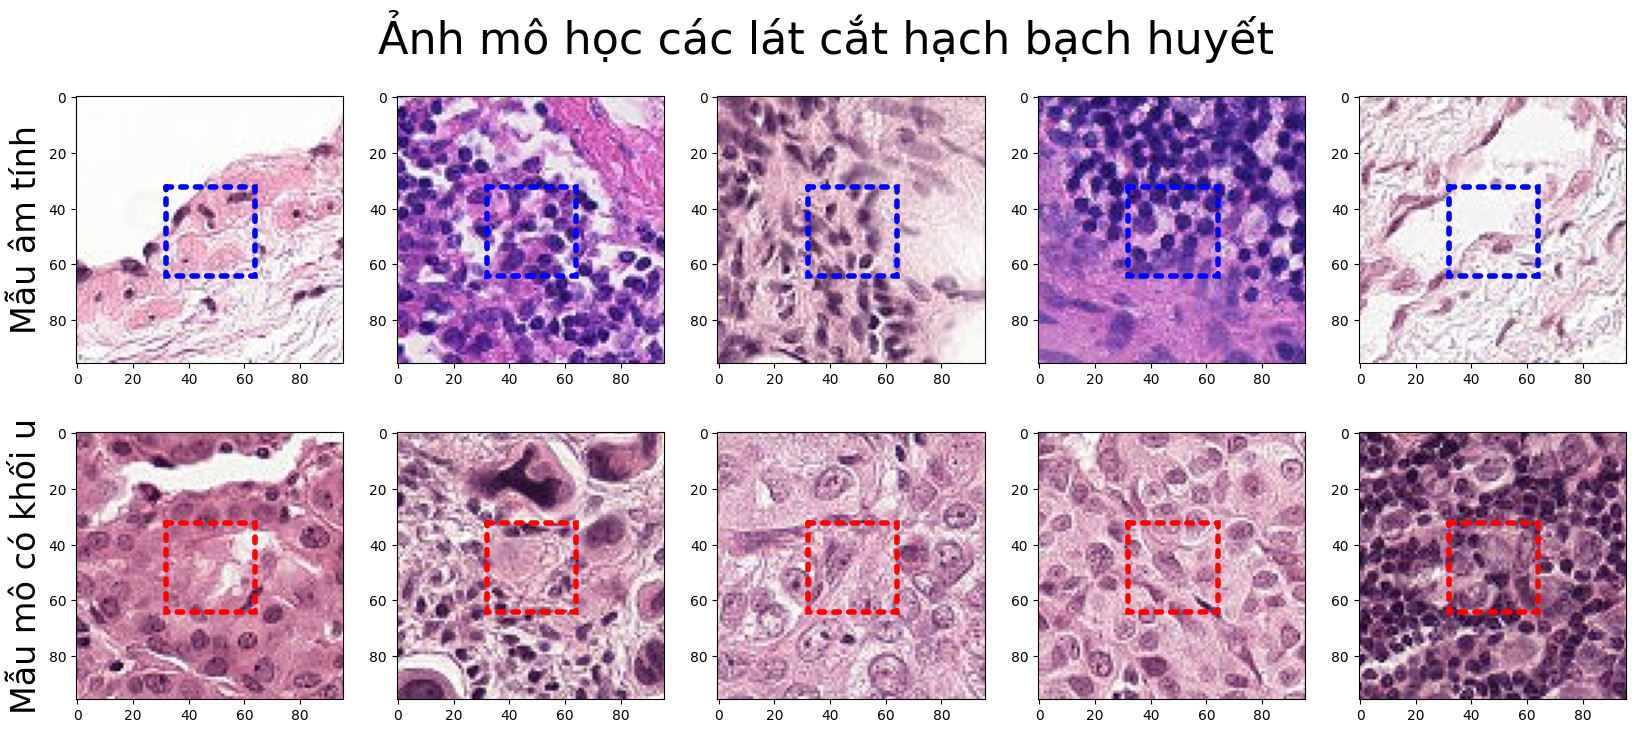

In [13]:
# Lấy mẫu ngẫu nhiên
shuffled_full_data = shuffle(full_data_df)

fig, ax = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Ảnh mô học các lát cắt hạch bạch huyết", fontsize=32)

# Mẫu âm tính
for i, idx in enumerate(shuffled_full_data[shuffled_full_data["label"] == 0]["id"][:5]):
    path = os.path.join(full_data_labels_path[:-11], idx)
    ax[0, i].imshow(read_image(path + ".tif"))
    # Vẽ khung hình chữ nhật
    box = patches.Rectangle(
        (32, 32),
        32,
        32,
        linewidth=4,
        edgecolor="b",
        facecolor="none",
        linestyle=":",
        capstyle="round",
    )
    ax[0, i].add_patch(box)
ax[0, 0].set_ylabel("Mẫu âm tính", fontsize=24)
# Mẫu dương tính (có khối u)
for i, idx in enumerate(shuffled_full_data[shuffled_full_data["label"] == 1]["id"][:5]):
    path = os.path.join(full_data_labels_path[:-11], idx)
    ax[1, i].imshow(read_image(path + ".tif"))
    # Vẽ khung hình chữ nhật
    box = patches.Rectangle(
        (32, 32),
        32,
        32,
        linewidth=4,
        edgecolor="r",
        facecolor="none",
        linestyle=":",
        capstyle="round",
    )
    ax[1, i].add_patch(box)
ax[1, 0].set_ylabel("Mẫu mô có khối u", fontsize=24)

In [14]:
# Minimal DataLoaders: no extra resize, no extra aug; only ImageNet normalization
from pathlib import Path

import pandas as pd
from fastai.vision.all import *

# Since your dataframes already have the "label" column, you only need to add the "filepath" column.
# We'll assume your train_df and val_df have an "id" column corresponding to the filename,
# and your images are stored in DATA_FOLDER/train/<id>.tif and DATA_FOLDER/val/<id>.tif (no label subfolder).

root = Path(DATA_FOLDER)


def add_filepath_column(df, split):
    # Assumes df has columns: 'id' and 'label'
    df = df.copy()
    # The images are stored in DATA_FOLDER/train/<id>.tif and DATA_FOLDER/val/<id>.tif
    df["filepath"] = df.apply(
        lambda row: str(root / split / f"{row['id']}.tif"), axis=1
    )
    return df


train_df = add_filepath_column(train_df, "train")
if DO_VAL:
    val_df = add_filepath_column(val_df, "val")

# Mark splits
train_df["is_valid"] = False
if DO_VAL:
    val_df["is_valid"] = True
    df_all = pd.concat([train_df, val_df], ignore_index=True)
else:
    df_all = train_df.copy()
df_all


,id,label,filepath,is_valid
0,854ed1a48d55f17b674cbb5a87bf41bf8dd51342,0,D:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\data\prepared_data\train\854ed1a48d55f17b674cbb5a87bf41bf8dd51342.tif,False
1,1b9b194b91ab720d2f1e4e2c1067680f98a4a434,1,D:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\data\prepared_data\train\1b9b194b91ab720d2f1e4e2c1067680f98a4a434.tif,False
2,f17b38d3a1480b51ff6558fedaa01899a612ade0,0,D:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\data\prepared_data\train\f17b38d3a1480b51ff6558fedaa01899a612ade0.tif,False
3,4f4e453db5316c09e99d909a48e66daebe81b660,0,D:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\data\prepared_data\train\4f4e453db5316c09e99d909a48e66daebe81b660.tif,False
4,9abd01816f80bf0668d6ec00bdc5c4f3e7b13e10,0,D:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\data\prepared_data\train\9abd01816f80bf0668d6ec00bdc5c4f3e7b13e10.tif,False
...,...,...,...,...
17596,a7a428e60387fa6f88910317c15ebe1821723589,0,D:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\data\prepared_data\val\a7a428e60387fa6f88910317c15ebe1821723589.tif,True
17597,6b92017850b7ec861bc61514a55da381d0b08a95,0,D:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\data\prepared_data\val\6b92017850b7ec861bc61514a55da381d0b08a95.tif,True
17598,4abc731c00e686af0151da626f795ec04c447979,0,D:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\data\prepared_data\val\4abc731c00e686af0151da626f795ec04c447979.tif,True
17599,e90832b536fa2f292f8317214461d9d91b2cd7d4,1,D:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\data\prepared_data\val\e90832b536fa2f292f8317214461d9d91b2cd7d4.tif,True


# Data loaders

In [15]:
from fastai.vision.all import *

# Build dls as before but fix batch_tfms and don't override after_batch
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock(vocab=[0, 1])),
    get_x=ColReader("filepath"),
    get_y=ColReader("label"),
    splitter=ColSplitter("is_valid"),
    # Upsample your 46×46 inputs to 224×224 for DenseNet-169
    # Use Pad to preserve aspect ratio if needed; with square inputs Squish is fine too.
    item_tfms=Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Reflection),
    batch_tfms=[
        IntToFloatTensor(),  # scale to [0,1]
        Normalize.from_stats(*imagenet_stats),  # ImageNet normalization
    ],
)

dls = dblock.dataloaders(df_all, bs=BATCH_SIZE, num_workers=NUM_WORKERS)

# sanity check
xb, yb = dls.one_batch()
print(
    f"Min: {xb.min().item()}, Max: {xb.max().item()}, Mean: {xb.mean().item()}, Std: {xb.std().item()}"
)

Min: -2.1179039478302, Max: 2.640000104904175, Mean: 0.6865726113319397, Std: 1.1468185186386108


In [16]:
# Add filepath column to test_df if not already present
test_df = add_filepath_column(test_df, "test")
# Test DL (no labels)
test_files = test_df["filepath"].tolist()
test_dl = dls.test_dl(test_files, with_labels=False)
len(dls.train), len(dls.valid), len(test_dl)


(412, 138, 138)

# Base learner creation

In [17]:
# Create learner with DenseNet-169 (single-logit head), PR-AUC metric

import torch.nn as nn
from fastai.vision.all import *
from torchvision.models import densenet169

base = densenet169(weights="IMAGENET1K_V1")
in_features = base.classifier.in_features
base.classifier = nn.Linear(in_features, 1)
# Change to F1 score:
from sklearn.metrics import f1_score
from fastai.metrics import Metric


class F1Score(Metric):
    def __init__(self, threshold=0.5):
        self.threshold = threshold

    def reset(self):
        self.preds = []
        self.targets = []

    def accumulate(self, learn):
        pred = learn.pred.sigmoid()
        targ = learn.y
        self.preds.append(pred)
        self.targets.append(targ)

    @property
    def value(self):
        if len(self.preds) == 0:
            return 0.0
        preds = torch.cat(self.preds).cpu().numpy()
        targets = torch.cat(self.targets).cpu().numpy()
        preds_binary = (preds >= self.threshold).astype(int)
        return f1_score(targets, preds_binary)


# Updated learner with F1 score
learn = Learner(
    dls,
    base,
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[F1Score()] if DO_VAL else [],
    cbs=[MixedPrecision()],
)

learn.model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [27]:
from pathlib import Path

# Save the trained model to disk for later use or inference.
# The model will be saved in the directory specified by MODELS_FOLDER with the given filename.
# MODELS_FOLDER should be an absolute or relative path string

MODELS_FOLDER = Path(MODELS_FOLDER)
MODELS_FOLDER.mkdir(parents=True, exist_ok=True)
learn.path = MODELS_FOLDER
learn.model_dir = "."  # save in this folder

In [ ]:
# Configure validation-driven model selection and early stopping
best_model_name = (
    f"densenet169-binary-f1-val_{DO_VAL}_furthertuning_{DO_FURTHER_TUNING}_best"
)

from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback

if DO_VAL:
    learn.add_cbs(
        [
            SaveModelCallback(
                monitor="f1_score",
                fname=best_model_name,
                comp=np.greater,
            ),
            EarlyStoppingCallback(
                monitor="f1_score", comp=np.greater, patience=EARLY_STOPPING_PATIENCE
            ),
        ]
    )

# Training

In [17]:
if DO_FURTHER_TUNING:
    # Setup paths
    learn.path = MODELS_FOLDER
    learn.model_dir = "."
    learn.load(f"densenet169-binary-f1_val_{DO_VAL}")  # Loads weights only
    # Optional: Verify it loaded correctly
    print(learn.model)

d:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\.venv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
d:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\.venv\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
d:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\.venv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.sc

valley: 5.248074739938602e-05 | steep: 0.033113110810518265


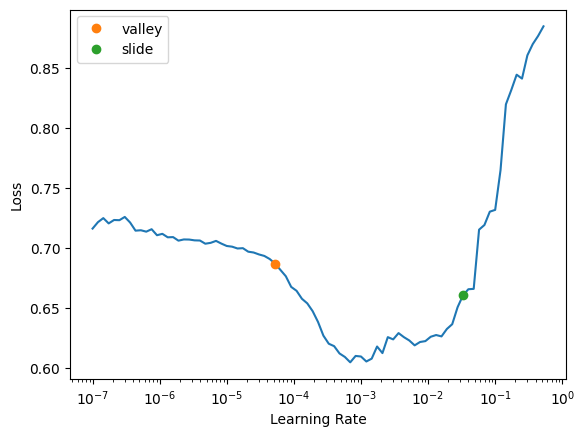

In [ ]:
# Phase 1: Train head only (callbacks preserved during training)
from fastai.vision.all import *

if DO_INITIAL_TUNING:
    # Temporarily disable tracker-style callbacks only for lr_find
    tracker_cbs = [cb for cb in learn.cbs if getattr(cb, "monitor", None) is not None]
    for cb in tracker_cbs:
        learn.remove_cb(cb)

    lr_valley, lr_steep = learn.lr_find(suggest_funcs=(valley, slide))
    print("valley:", lr_valley, "| steep:", lr_steep)

    # Re-enable the same callback instances for training
    learn.add_cbs(tracker_cbs)
elif DO_FURTHER_TUNING:
    lr_valley = 5.248074739938602e-05  # Hard coded values from printed output, do this for further finetuning
    base_lr = float(lr_valley) if lr_valley is not None else 1e-3

In [ ]:
# Train head (frozen)
if DO_INITIAL_TUNING:
    learn.freeze()
    base_lr = float(lr_valley) if lr_valley is not None else 1e-3
    learn.fit_one_cycle(HEAD_TUNING_EPOCHS, lr_max=base_lr)

epoch,train_loss,valid_loss,f1_score,time
0,0.280445,0.243724,0.871374,49:25
1,0.196736,0.199123,0.907042,47:58
2,0.077874,0.209749,0.898779,52:01


Better model found at epoch 0 with f1_score value: 0.8713741576325813.
Better model found at epoch 1 with f1_score value: 0.9070422535211268.


In [ ]:
# Phase 2: Fine-tune the whole model (unfrozen) with discriminative LRs
if DO_INITIAL_TUNING:
    learn.unfreeze()
    learn.fit_one_cycle(
        INITIAL_FULL_TUNING_EPOCHS, lr_max=slice(base_lr / 100, base_lr)
    )

d:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\.venv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
d:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\.venv\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
d:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\.venv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.sc

epoch,train_loss,valid_loss,f1_score,time
0,0.090434,0.207482,0.903523,47:47
1,0.086370,0.203531,0.907082,47:44
2,0.056528,0.313190,0.893423,47:47
3,0.069708,0.271946,0.891247,46:22
4,0.048473,0.253648,0.907257,46:18
5,0.033146,0.303324,0.899166,45:51
6,0.023670,0.286111,0.909969,45:54
7,0.023643,0.396909,0.881664,46:45
8,0.017601,0.391831,0.888713,46:00
9,0.008665,0.333001,0.911756,43:48


Better model found at epoch 0 with f1_score value: 0.9035230352303523.
Better model found at epoch 1 with f1_score value: 0.9070821529745042.
Better model found at epoch 4 with f1_score value: 0.9072569347156066.
Better model found at epoch 6 with f1_score value: 0.9099687588753195.
Better model found at epoch 9 with f1_score value: 0.9117564138708768.
No improvement since epoch 9: early stopping


In [ ]:
if DO_FURTHER_TUNING:
    learn.fit_one_cycle(
        FURTHER_FULL_TUNING_EPOCHS, lr_max=slice(base_lr / 100, base_lr)
    )

# Model reloading

In [ ]:
model_export = f"export-f1_val_{DO_VAL}_furthertuning_{DO_FURTHER_TUNING}.pkl"
latest_model_name = (
    f"densenet169-binary-f1_val_{DO_VAL}_furthertuning_{DO_FURTHER_TUNING}"
)
if DO_INITIAL_TUNING or DO_FURTHER_TUNING:
    learn.export(model_export)
    # Save manually
    learn.save(latest_model_name)  # -> MODELS_FOLDER/densenet169-binary-f1.pth
    # Evaluate the model on the validation set and print the results (e.g., loss and metrics).
    if DO_VAL:
        preds, targs = learn.get_preds(dl=dls.valid)
        from sklearn.metrics import f1_score, log_loss

        probs = preds.sigmoid().squeeze().detach().cpu().numpy().ravel()
        y_true = targs.cpu().numpy().ravel()
        val_loss = log_loss(y_true, probs)
        f1 = f1_score(y_true, probs > 0.5)
        print(f"Validation Loss (log_loss): {val_loss:.4f}, F1 Score: {f1:.4f}")

In [ ]:
# Load later in any session (after recreating dls/model architecture):
# Set model_dir to MODELS_FOLDER, so .pth files load from this folder
learn.path = MODELS_FOLDER
learn.model_dir = "."
if DO_LOAD_LAST_WEIGHTS:
    # suppress saved optimizer warnings by with_opt=False
    learn.load(latest_model_name, with_opt=False)
elif DO_LOAD_BEST_WEIGHTS:
    learn.load(best_model_name, with_opt=False)

if DO_VAL:
    import numpy as np
    from sklearn.metrics import (
        f1_score,
        precision_recall_curve,
        precision_score,
        recall_score,
        log_loss,
    )

    # Predict on validation set
    preds, targs = learn.get_preds(dl=dls.valid)
    probs_np = preds.sigmoid().squeeze().cpu().numpy().ravel()
    y_true = targs.cpu().numpy().ravel()

    # Compute precision-recall curve for optimal F1
    prec, rec, thr = precision_recall_curve(y_true, probs)
    f1_scores = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = f1_scores.argmax()
    best_thresh = float(thr[best_idx]) if len(thr) else 0.5

    # Print metrics for threshold 0.5 and optimal validation threshold
    f1_default = f1_score(y_true, probs > 0.5)
    f1_best = f1_score(y_true, probs > best_thresh)
    val_loss = log_loss(y_true, probs)
    print(f"Validation Loss (log_loss): {val_loss:.4f}")
    print(f"Default threshold=0.5: F1={f1_default:.4f}")
    print(f"Best val threshold: {best_thresh:.4f} | F1={f1_best:.4f}")


d:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\.venv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
d:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\.venv\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
d:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\.venv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.sc

Validation Loss (log_loss): 0.5755
Default threshold=0.5: F1=0.6055
Best val threshold: 0.6734 | F1=0.9122


In [40]:
if DO_VAL:
    preds, _ = learn.get_preds(dl=test_dl)
    probs = preds.sigmoid().squeeze()
    probs_np = probs.detach().cpu().numpy().ravel()

In [36]:
if not DO_VAL:
    # Correctly compute probabilities and PR-AUC
    import numpy as np

    # Get logits → probs
    preds, _ = learn.get_preds(dl=test_dl)  # preds: logits [N, 1]
    probs = preds.sigmoid().squeeze()  # CALL squeeze() — not the function object

    # Convert to numpy
    probs_np = probs.detach().cpu().numpy().ravel()


In [41]:
labels_np = np.asarray(test_df["label"].values).astype(int).ravel()
print(f"probs_np shape: {probs_np.shape}, labels_np shape: {labels_np.shape}")

# Expect best_thresh from previous cell; fall back to 0.5 if missing
try:
    _ = best_thresh
except NameError:
    best_thresh = 0.5

y_pred = (probs_np >= best_thresh).astype(int)
print(f"Pred positives: {y_pred.sum()} / {y_pred.shape[0]} ({y_pred.mean():.3%})")


probs_np shape: (4401,), labels_np shape: (4401,)
Pred positives: 1657 / 4401 (37.651%)


In [42]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    average_precision_score,  # Keep this for comparison
)

# If test_df has labels, compute metrics
if "label" in test_df.columns:
    labels_np = np.asarray(test_df["label"].values).astype(int).ravel()
    if probs_np.shape[0] == labels_np.shape[0]:
        # Primary metric is now F1 score
        f1 = f1_score(labels_np, y_pred)
        prec = precision_score(labels_np, y_pred, zero_division=0)
        rec = recall_score(labels_np, y_pred, zero_division=0)
        pr_auc = average_precision_score(labels_np, probs_np)  # Keep for comparison

        print(
            f"Test F1: {f1:.5f} | Precision: {prec:.5f} | Recall: {rec:.5f} | PR-AUC: {pr_auc:.5f}"
        )
    else:
        print(
            f"Warning: label/score length mismatch: {labels_np.shape} vs {probs_np.shape}"
        )

Test F1: 0.91306 | Precision: 0.94750 | Recall: 0.88103 | PR-AUC: 0.97182


In [43]:
# 1) Submission-style file (binary labels)
sub_df = test_df[["id"]].copy()
sub_df["label"] = y_pred
sub_path = os.path.join(
    DATA_FOLDER,
    f"test_predictions_duc_val_{DO_VAL}_furthertuning_{DO_FURTHER_TUNING}.csv",
)
sub_df.to_csv(sub_path, index=False)
print("Saved:", sub_path)

# 2) Probabilities file (keep for analysis or if platform accepts probs)
sub_prob = test_df[["id"]].copy()
sub_prob["prob"] = probs_np.astype(float)
sub_prob_path = os.path.join(
    DATA_FOLDER, f"test_probs_duc_val_{DO_VAL}_furthertuning_{DO_FURTHER_TUNING}.csv"
)
sub_prob.to_csv(sub_prob_path, index=False)
print("Saved:", sub_prob_path)

Saved: D:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\data\prepared_data\test_predictions_duc_val_True_furthertuning_False.csv
Saved: D:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\data\prepared_data\test_probs_duc_val_True_furthertuning_False.csv
